In [7]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [8]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

   01 wt_0h 02 wt_2h 03 arm1db.2_0h 04 arm1db.2_2h 05 arm1db.4_0h
1 0.8867914 30.62720      1.1381310       34.45739             NA
2 1.0767376 29.99690      0.7937005       28.77495             NA
3 1.0472941 29.58393      1.1070088       27.79477             NA
4 0.7809669 19.67710             NA             NA      1.0304920
5 1.2170035 20.09056             NA             NA      0.9287314
6 1.0521448 20.09056             NA             NA      1.0448772
  06 arm1db.4_2h 07 flg22_0h 08 flg22_2h   Group
1             NA   0.8908987    89.47473 Trial01
2             NA   1.1198716    94.57640 Trial01
3             NA   1.0023132    87.02804 Trial01
4       18.74515   1.7983411    91.25168 Trial01
5       19.40620   1.0116194    86.92981 Trial01
6       17.61150   0.5496811    87.53446 Trial01
# A tibble: 6 × 3
  ind            Group   values
  <chr>          <chr>    <dbl>
1 01 wt_0h       Trial01  0.887
2 02 wt_2h       Trial01 30.6  
3 03 arm1db.2_0h Trial01  1.14 
4 04 arm1db.2_2h 

# A tibble: 6 × 3
  Treatment Trial   VALUE
  <chr>     <chr>   <dbl>
1 01 wt_0h  Trial01 0.887
2 01 wt_0h  Trial01 1.08 
3 01 wt_0h  Trial01 1.05 
4 01 wt_0h  Trial01 0.781
5 01 wt_0h  Trial01 1.22 
6 01 wt_0h  Trial01 1.05 


[1] 32 34

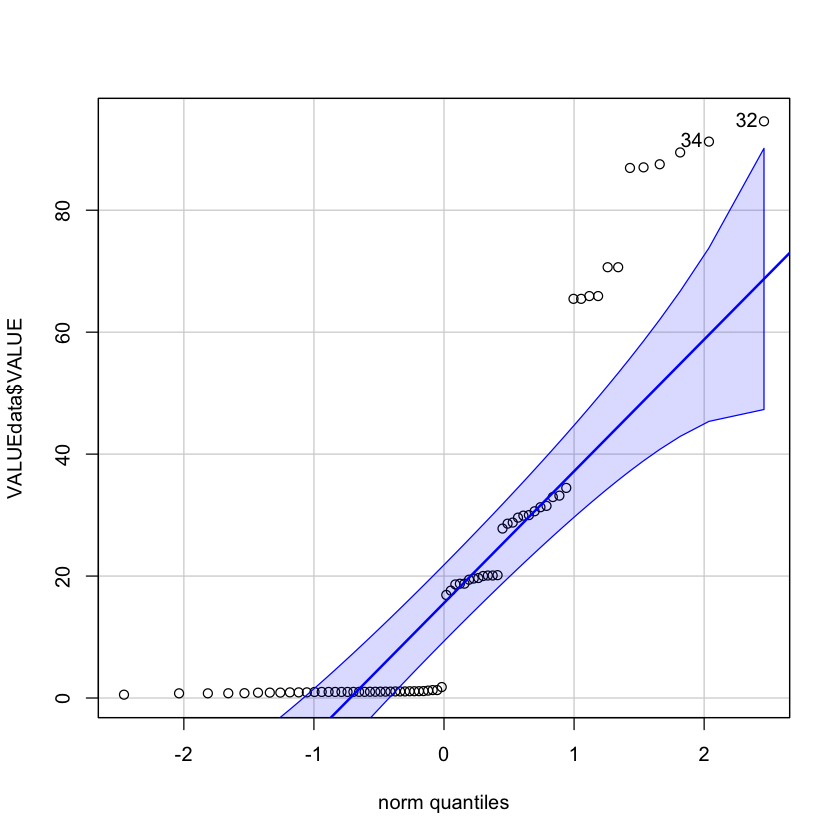

In [9]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   474.4    497.2   -227.2    454.4       62 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.08750 -0.40472  0.04316  0.31150  2.66663 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  2.316   1.522   
 Residual             31.104   5.577   
Number of obs: 72, groups:  Trial, 2

Fixed effects:
                          Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)              1.0060476  1.9364789 10.5681997   0.520    0.614    
Treatment02 wt_2h       24.0952738  2.2768451 70.0000000  10.583 3.60e-16 ***
Treatment03 arm1db.2_0h  0.0004445  2.7885543 70.0000000   0.000    1.000    
Treatment04 arm1db.2_2h 23.2130523  2.7885543 70.0000000   8.324 4.61e-12 ***
Treatment05 arm1db.4_0h -0.0029826  2.7885543 70.0000

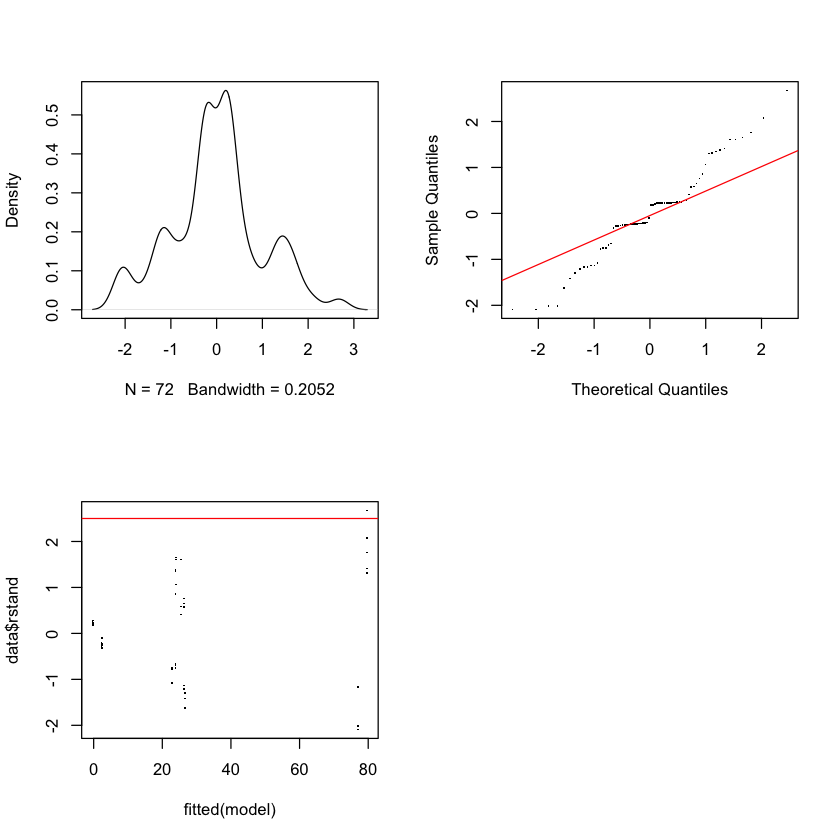

In [10]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [11]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq         NumDF       DenDF       F value     
 Min.   :54238   Min.   :7748   Min.   :7   Min.   :70   Min.   :249.1  
 1st Qu.:54238   1st Qu.:7748   1st Qu.:7   1st Qu.:70   1st Qu.:249.1  
 Median :54238   Median :7748   Median :7   Median :70   Median :249.1  
 Mean   :54238   Mean   :7748   Mean   :7   Mean   :70   Mean   :249.1  
 3rd Qu.:54238   3rd Qu.:7748   3rd Qu.:7   3rd Qu.:70   3rd Qu.:249.1  
 Max.   :54238   Max.   :7748   Max.   :7   Max.   :70   Max.   :249.1  
     Pr(>F)         
 Min.   :7.553e-47  
 1st Qu.:7.553e-47  
 Median :7.553e-47  
 Mean   :7.553e-47  
 3rd Qu.:7.553e-47  
 Max.   :7.553e-47  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                       Estimate Std. Error z value Pr(>|z|)    
02 wt_2h - 01 wt_0h == 0              2.410e+01  2